## Run inference test
Test with images in repository `CAPTCHA_images/test` directory.

In [54]:
import cv2
import numpy as np
import os
import sys
# run on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from distutils.version import StrictVersion
from collections import defaultdict
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import time

In [131]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = './exported_graphs/faster_rcnn_inception_v2_coco/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './CAPTCHA_training/labelmap.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR (./test).
PATH_TO_TEST_IMAGES_DIR = './CAPTCHA_images/test/'
PATH_TO_TRAIN_IMAGES_DIR = './CAPTCHA_images/train/'

assert os.path.isfile(PATH_TO_CKPT)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['./CAPTCHA_images/test\\100_C875F.jpg', './CAPTCHA_images/test\\101_4698.jpg', './CAPTCHA_images/test\\82_BAEBB.jpg', './CAPTCHA_images/test\\83_36155.jpg', './CAPTCHA_images/test\\84_A65.jpg', './CAPTCHA_images/test\\85_A276.jpg', './CAPTCHA_images/test\\86_87442.jpg', './CAPTCHA_images/test\\87_DBC7.jpg', './CAPTCHA_images/test\\88_633.jpg', './CAPTCHA_images/test\\89_E42.jpg', './CAPTCHA_images/test\\90_44D1.jpg', './CAPTCHA_images/test\\91_544.jpg', './CAPTCHA_images/test\\92_A19C.jpg', './CAPTCHA_images/test\\93_4E735.jpg', './CAPTCHA_images/test\\94_1691.jpg', './CAPTCHA_images/test\\95_734F.jpg', './CAPTCHA_images/test\\96_A9E83.jpg', './CAPTCHA_images/test\\97_E5A4.jpg', './CAPTCHA_images/test\\98_AFA.jpg', './CAPTCHA_images/test\\99_9FD6.jpg']


In [83]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

NUM_CLASSES = 37

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [143]:
def Captcha_detection_old(image_path):
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

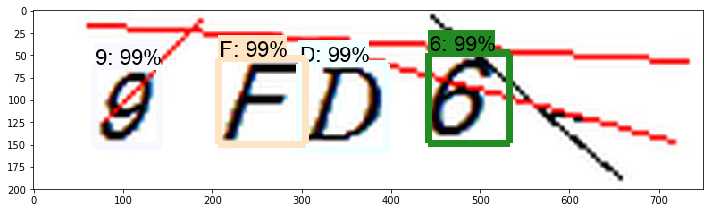

In [144]:
Captcha_detection_old(TEST_IMAGE_PATHS[19])

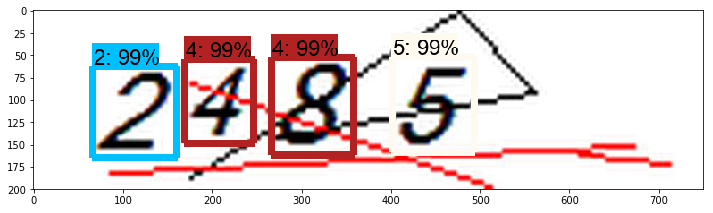

In [145]:
Captcha_detection_old(TRAIN_IMAGE_PATHS[10])

In [ ]:
# Model preparation 
PATH_TO_FROZEN_GRAPH = './exported_graphs/faster_rcnn_inception_v2_coco/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './CAPTCHA_training/labelmap.pbtxt'
NUM_CLASSES = 37


# Load a (frozen) Tensorflow model into memory.
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [99]:
with detection_graph.as_default():
    sess = tf.Session(graph=detection_graph)

In [103]:
def Captcha_detection(image, average_distance_error=3):
    start_time = time.time()
    # Open image
    image_np = cv2.imread(image)
    # Resize image if needed
    image_np = cv2.resize(image_np, (0,0), fx=3, fy=3) 
    # To get real color we do this:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
    print("Before Session Run --- %s seconds ---" % (time.time() - start_time))
    
    # Visualization of the results of a detection.
    (boxes, scores, classes, num_detections) = sess.run(
      [boxes, scores, classes, num_detections],
      feed_dict={image_tensor: image_np_expanded})
    
    print("After Session Run --- %s seconds ---" % (time.time() - start_time))
    
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.squeeze(boxes),
      np.squeeze(classes).astype(np.int32),
      np.squeeze(scores),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
    # Show image with detection
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    # Save image with detection
    #cv2.imwrite("Predicted_captcha.jpg", cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))


    # Bellow we do filtering stuff
    captcha_array = []
    # loop our all detection boxes
    for i,b in enumerate(boxes[0]):
        for Symbol in range(37):
            if classes[0][i] == Symbol: # check if detected class equal to our symbols
                if scores[0][i] >= 0.65: # do something only if detected score more han 0.65
                                    # x-left        # x-right
                    mid_x = (boxes[0][i][1]+boxes[0][i][3])/2 # find x coordinates center of letter
                    # to captcha_array array save detected Symbol, middle X coordinates and detection percentage
                    captcha_array.append([category_index[Symbol].get('name'), mid_x, scores[0][i]])

    # rearange array acording to X coordinates datected
    for number in range(20):
        for captcha_number in range(len(captcha_array)-1):
            if captcha_array[captcha_number][1] > captcha_array[captcha_number+1][1]:
                temporary_captcha = captcha_array[captcha_number]
                captcha_array[captcha_number] = captcha_array[captcha_number+1]
                captcha_array[captcha_number+1] = temporary_captcha


    # Find average distance between detected symbols
    average = 0
    captcha_len = len(captcha_array)-1
    while captcha_len > 0:
        average += captcha_array[captcha_len][1]- captcha_array[captcha_len-1][1]
        captcha_len -= 1
    # Increase average distance error
    average = average/(len(captcha_array)+average_distance_error)

    
    captcha_array_filtered = list(captcha_array)
    captcha_len = len(captcha_array)-1
    while captcha_len > 0:
        # if average distance is larger than error distance
        if captcha_array[captcha_len][1]- captcha_array[captcha_len-1][1] < average:
            # check which symbol has higher detection percentage
            if captcha_array[captcha_len][2] > captcha_array[captcha_len-1][2]:
                del captcha_array_filtered[captcha_len-1]
            else:
                del captcha_array_filtered[captcha_len]
        captcha_len -= 1

    # Get final string from filtered CAPTCHA array
    captcha_string = ""
    for captcha_letter in range(len(captcha_array_filtered)):
        captcha_string += captcha_array_filtered[captcha_letter][0]
        
    print("Actual Filtering --- %s seconds ---" % (time.time() - start_time))
    
    return captcha_string

Before Session Run --- 0.017001628875732422 seconds ---
After Session Run --- 1.9651966094970703 seconds ---
Actual Filtering --- 2.1322131156921387 seconds ---


'A19C'

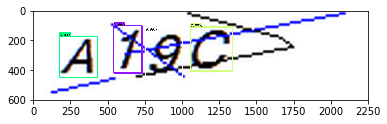

In [129]:
Captcha_detection(TEST_IMAGE_PATHS[12], 6)

Before Session Run --- 0.020002126693725586 seconds ---
After Session Run --- 2.2402241230010986 seconds ---
Actual Filtering --- 2.360236167907715 seconds ---


'2445'

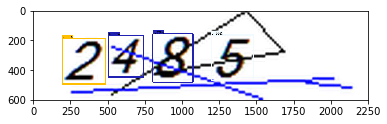

In [142]:
Captcha_detection(TRAIN_IMAGE_PATHS[10], 6)

### Benchmark TensorFlow inference speed

In [5]:
import time

def run_inference_benchmark(image, graph, trial=20, gpu=True):
    """Run TensorFlow inference benchmark.

    Arguments:
        image {np.array} -- Input image as an Numpy array.
        graph {tf.Graph} -- TensorFlow graph object.

    Keyword Arguments:
        trial {int} -- Number of inference to run for averaging. (default: {20})
        gpu {bool} -- Use Nvidia GPU when available. (default: {True})

    Returns:
        int -- Frame per seconds benchmark result.
    """

    with graph.as_default():
        if gpu:
            config = tf.ConfigProto()
        else:
            config = tf.ConfigProto(device_count={"GPU": 0})
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                "num_detections",
                "detection_boxes",
                "detection_scores",
                "detection_classes",
                "detection_masks",
            ]:
                tensor_name = key + ":0"
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name
                    )
            if "detection_masks" in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict["detection_boxes"], [0])
                detection_masks = tf.squeeze(tensor_dict["detection_masks"], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict["num_detections"][0], tf.int32
                )
                detection_boxes = tf.slice(
                    detection_boxes, [0, 0], [real_num_detection, -1]
                )
                detection_masks = tf.slice(
                    detection_masks, [0, 0, 0], [real_num_detection, -1, -1]
                )
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1]
                )
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8
                )
                # Follow the convention by adding back the batch dimension
                tensor_dict["detection_masks"] = tf.expand_dims(
                    detection_masks_reframed, 0
                )
            image_tensor = tf.get_default_graph().get_tensor_by_name(
                "image_tensor:0"
            )

            # Run inference
            times = []
            # Kick start the first inference which takes longer and followings.
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
            )
            for i in range(trial):
                start_time = time.time()
                output_dict = sess.run(
                    tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
                )
                delta = time.time() - start_time
                times.append(delta)
            mean_delta = np.array(times).mean()
            fps = 1 / mean_delta
            print("average(sec):{:.3f},fps:{:.2f}".format(mean_delta, fps))

    return fps

image = Image.open(TEST_IMAGE_PATHS[-1])
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection benchmark.
fps = run_inference_benchmark(image_np, detection_graph, trial=20, gpu=False)

average(sec):2.057,fps:0.49
